# Kepler Exoplanets - Medallion Architecture with Streaming

This proof of concept shows how Apache Spark (on Databricks) can be used to build a streaming medallion architecture pipeline to obtain real-time insights/figures about the Kepler exoplanets. While somewhat niche, this code could serve as the backend of a web application which displays the total number of exoplanets discovered in real-time. Kepler exoplanets are those discovered by Nasa's Kepler Space Telescope, which operated between 2009 and 2018.

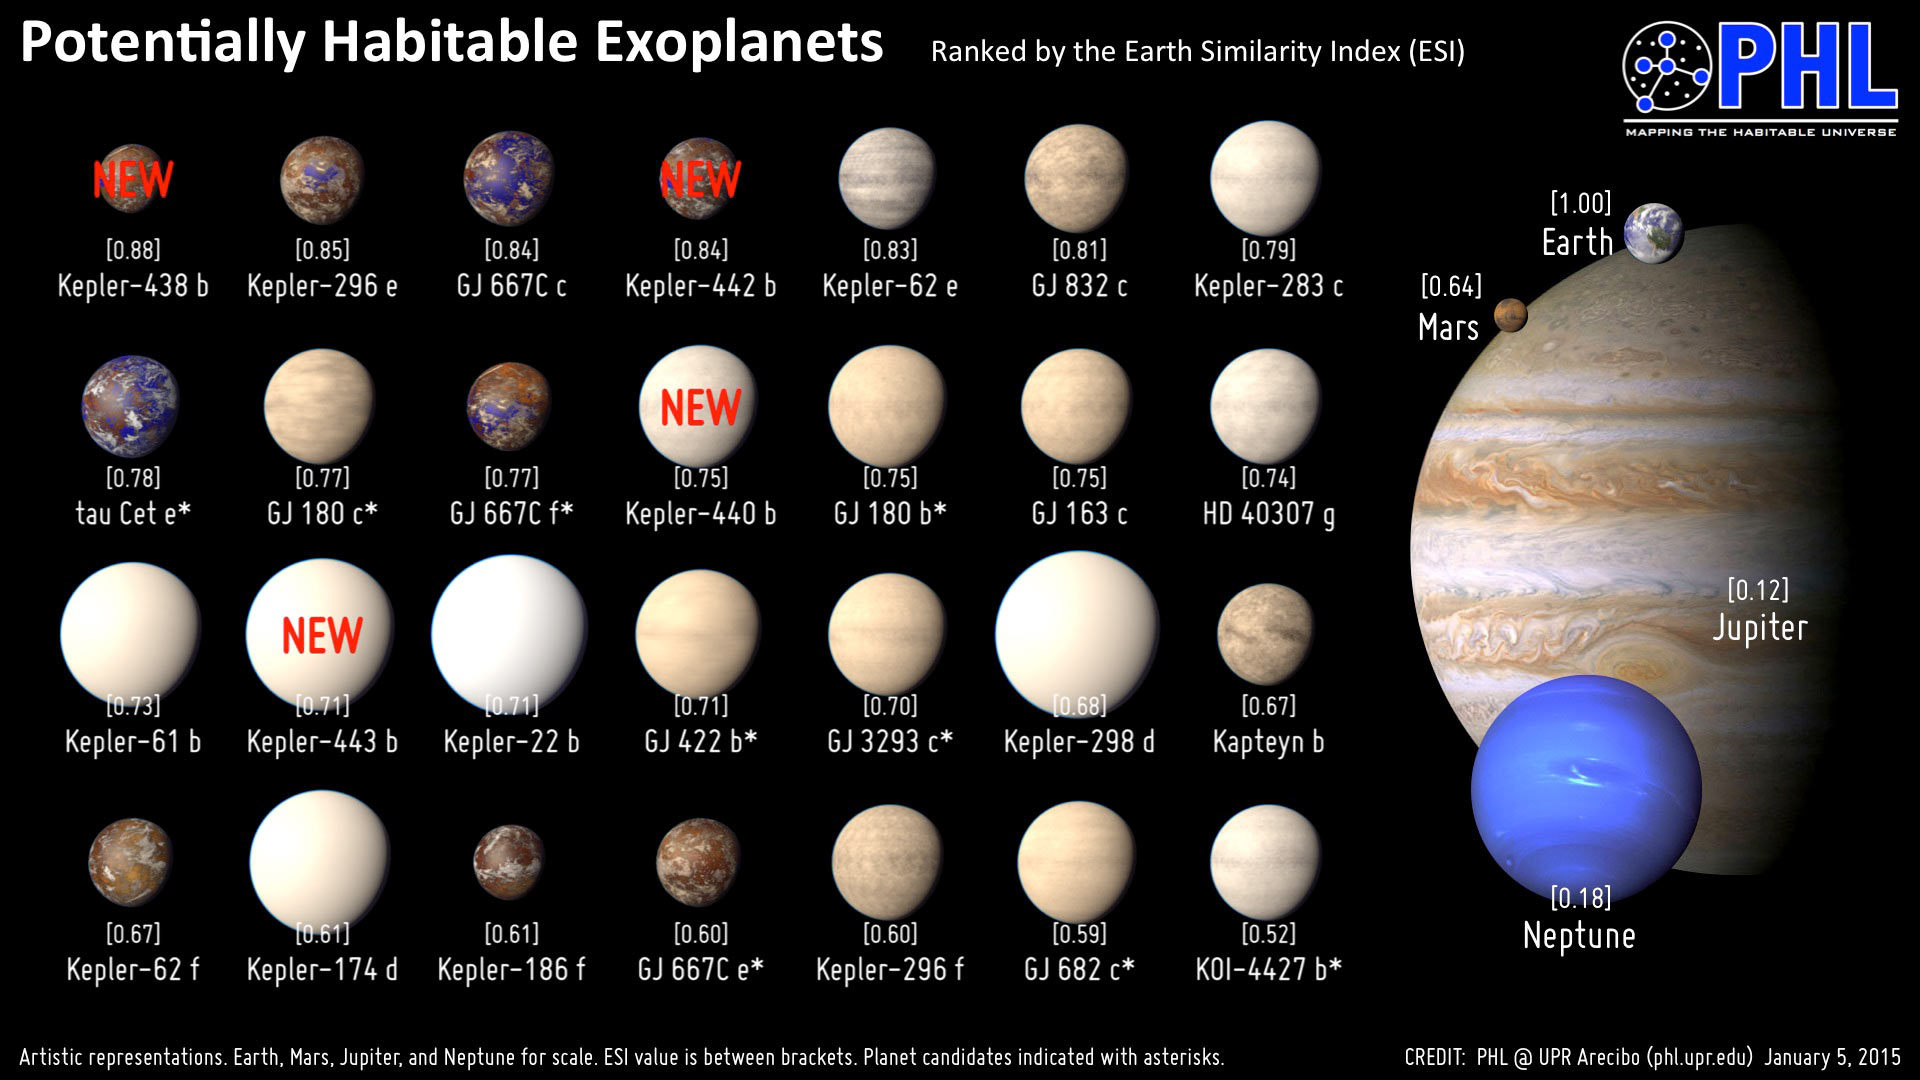

In [ ]:
# Import libs
from pyspark.sql import *

In [0]:
# Create dataframe from table
df=spark.sql("SELECT * FROM default.exoplanets_objects_sept21")
df.show(5)

+------+--------------+----------+------------+--------------+----------+
|row_id|kepler_star_id|kepoi_name| kepler_name|   disposition|confidence|
+------+--------------+----------+------------+--------------+----------+
|     1|      10797460| K00752.01|Kepler-227 b|     CONFIRMED|       1.0|
|     2|      10797460| K00752.02|Kepler-227 c|     CONFIRMED|     0.969|
|     3|      10811496| K00753.01|        null|FALSE POSITIVE|       0.0|
|     4|      10848459| K00754.01|        null|FALSE POSITIVE|       0.0|
|     5|      10854555| K00755.01|Kepler-664 b|     CONFIRMED|       1.0|
+------+--------------+----------+------------+--------------+----------+
only showing top 5 rows



### Data Dictionary

- row_id (aliased later as surrogate_key) - A surrogate key that uniquely identifies each Kepler planet
- kepler_star_id - The unique ID of the Kepler planet's star; a single star can have more than one orbiting exoplanet
- kepler_name (aliased later as exoplanet_name) - The official name of an exoplanet
- disposition - The exoplanet's discovery status (can be one of "confirmed", "false positive", or "candidate")
- confidence - The probability that the Kepler exoplanet actually exists (1 corresponds to definitely exists, while 0 corresponds to definitely does not exist)
- kepoi_name - The official name for the *Kepler Object of Interest* rather than the planetary name (to be dropped)

In [0]:
# Write table to dbfs
# df.write.format("delta").save("dbfs:/mnt/exoplanet_objects")

In [0]:
# Create function to load files incrementally
counter=0
def load_new_data():
    helper_list=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    global counter
    try:
        df=spark.sql("SELECT * FROM default.exoplanets_objects_sept21 WHERE row_id >= {0} AND row_id < {1}".format(helper_list[counter], helper_list[counter+1]))
        df.write.option("header", True).mode("append").format("delta").save("dbfs:/dbfs/mnt/exoplanets_medallion_sept21")
        counter+=1
        spark.readStream.load("dbfs:/dbfs/mnt/exoplanets_medallion_sept21").createOrReplaceTempView("exoplanets_raw_final")
    except:
        print("All available data has been loaded.")

In [0]:
# Load in first ~ 1,000 records
load_new_data() 

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW exoplanets_temp AS (
    SELECT *, current_timestamp() AS arrival_time
    FROM exoplanets_raw_final
)

In [0]:
%sql
SELECT COUNT(*)
FROM exoplanets_temp

count(1)
999


In [0]:
# Write contents of exoplanets_temp to bronze table
(spark.table("exoplanets_temp")
    .writeStream
    .format("delta")
    .option("checkpointLocation", "dbfs:/mnt/exoplanets/checkpoin/bronze")
    .outputMode("append")
    .table("bronze_exoplanets"))

Out[95]: <pyspark.sql.streaming.query.StreamingQuery at 0x7f0a82694c40>

In [0]:
# Read bronze stream
(spark.readStream
  .table("bronze_exoplanets")
  .createOrReplaceTempView("exoplanets_bronze_temp"))

In [2]:
# Refine bronze table w/ aliases & by removing records where disposition="False Positive" before loading into silver table

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW exoplanets_bronze_temp2 AS (
  SELECT row_id AS surrogate_key, kepler_star_id, kepler_name AS exoplanet_name, disposition, confidence, arrival_time
  FROM exoplanets_bronze_temp
  WHERE disposition<>"FALSE POSITIVE"
)

In [0]:
# Write results to silver table
(spark.table("exoplanets_bronze_temp2")
      .writeStream
      .format("delta")
      .option("checkpointLocation", "dbfs:/mnt/exoplanets/checkpoints/silver")
      .outputMode("append")
      .table("silver_exoplanets"))

Out[100]: <pyspark.sql.streaming.query.StreamingQuery at 0x7f0a82380700>

In [1]:
# Load next ~ 1,000 records
load_data()

In [0]:
%sql
SELECT DISTINCT disposition
FROM silver_exoplanets

disposition
CONFIRMED
CANDIDATE


In [0]:
%sql
SELECT COUNT(*) FROM silver_exoplanets

count(1)
1330


In [0]:
# Read silver stream into temporary table
(spark.readStream
  .table("silver_exoplanets")
  .createOrReplaceTempView("exoplanets_silver_temp"))

In [0]:
%sql
CREATE OR REPLACE TEMPORARY VIEW exoplanets_gold_temp AS (
  SELECT kepler_star_id, COUNT(exoplanet_name) AS num_planets
  FROM xoplanets_silver_temp
  GROUP BY kepler_star_id)

In [0]:
# Write to gold table (business level aggregates)
(spark.table("exoplanets_gold_temp")
    .writeStream
    .format("delta")
    .outputMode("complete")
    .option("checkpointLocation", "dbfs:/mnt/exoplanets/checkpoints/gold")
    .trigger(once=True)
    .table("exoplanets_gold"))

Out[107]: <pyspark.sql.streaming.query.StreamingQuery at 0x7f0a82542c40>

In [0]:
# Query below shows which star(s) has the most planets

In [0]:
%sql
SELECT *
FROM exoplanets_gold
ORDER BY num_planets DESC
LIMIT 10

kepler_star_id,num_planets
6962977,10
9787239,10
8150320,10
6541920,10
5436502,10
7366258,8
4139816,8
10875245,8
5880320,8
11014932,8


In [0]:
%sql
SELECT COUNT(*) FROM exoplanets_gold

count(1)
443


In [0]:
# Stop streams
for s in spark.streams.active:
    print("Stopping stream: " + s.id)
    s.stop()

Stopping stream: 9c024d86-3981-4c92-bf0e-be437569ab75
Stopping stream: 6d6d60d2-e3b2-4162-abdc-0db36210c40c
Stopping stream: 81a54cf4-3743-48da-9a26-effebedcaade
Stopping stream: de318170-f1f4-4d27-98e0-32d60a939193
